In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from keras import Model
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, Dense, Dropout, LSTM, Flatten
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from keras import Model
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, Dense, Dropout, LSTM, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, average_precision_score
import seaborn as sb
from imblearn.under_sampling import RandomUnderSampler

Data source: 

# Project variables

In [2]:
m_name = "clickbait v2"
p_dir = os.path.join("../cb models", m_name)

In [3]:
def create_dir(dir_path: str):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

In [4]:
def clear_dir(dir_path: str):
    for item in os.listdir(dir_path):
        fp = os.path.join(dir_path, item)
        if os.path.isfile(fp):
            os.remove(fp)
        if os.path.isdir(fp):
            rmtree(fp)

In [5]:
create_dir(p_dir)
clear_dir(p_dir)

# Prepare dataset

In [6]:
df = pd.read_csv("../cb models/clickbait_data.csv")
df.rename(columns={"headline": "title"}, inplace=True)
df = df.loc[df.title.str.len() <= 100, :]
df.shape

(31865, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31865 entries, 0 to 31999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      31865 non-null  object
 1   clickbait  31865 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 746.8+ KB


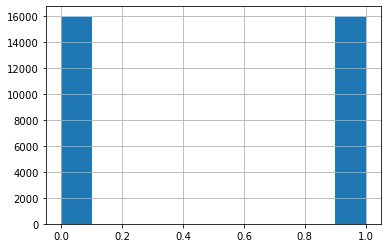

In [8]:
# cat_lbl = ["very low", "low", "high", "very high"]
# df.loc[:, "clickbait"] = pd.qcut(df.clickbait, len(cat_lbl), labels=cat_lbl, precision=6)
df["clickbait"].hist()
plt.show()

In [9]:
y = df["clickbait"]
x = df.loc[:, [c for c in df if c != "clickbait"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=4711)

x_train.to_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train.to_pickle(os.path.join(p_dir, "y_train.pkl"))
# x_val.to_pickle(os.path.join(p_dir,"x_val.pkl"))
# y_val.to_pickle(os.path.join(p_dir, "y_val.pkl"))
x_test.to_pickle(os.path.join(p_dir,"x_test.pkl"))
y_test.to_pickle(os.path.join(p_dir, "y_test.pkl"))

print(x_train.shape[0], x_test.shape[0])

25492 6373


# Build the model

In [10]:
def preprocessing(df: pd.DataFrame, remove_stopwords: bool=False) -> pd.DataFrame:
    field = "title"
    stw = set(stopwords.words("english"))
    
    def cleanse_row(row, field, stw, stopwords=False):
        # Remove HTML from text
        soup = BeautifulSoup(row[field])
        row[field] = soup.get_text()
        
        # Remove stopwords
        if stopwords:
            row[field] = " ".join([w for w in row[field].split() if w not in stw])
        
        return row
    
    df = df.apply(lambda row: cleanse_row(row, field, stw, remove_stopwords), axis=1)
    return df["title"]

In [11]:
# Download the stopwork corpus
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
remove_stopwords = False

def preprocess_data(x: pd.DataFrame, remove_stopwords: bool=False) -> list():
    x_pp = preprocessing(x, remove_stopwords)
    x_pp = x_pp.tolist()
    return x_pp

In [13]:
x_train_pp = preprocess_data(x_train)
x_test_pp = preprocess_data(x_test)

In [14]:
pt_model = "distilbert-base-uncased"
tok = DistilBertTokenizer.from_pretrained(pt_model, do_lower=True, add_special_tokens=True, max_length=100, pad_to_max_length=True)

In [15]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=100, padding="max_length", return_attention_mask=True, 
                                       return_token_type_ids=True)
        input_ids.append(inputs["input_ids"])
        input_masks.append(inputs["attention_mask"])
        input_segments.append(inputs["token_type_ids"])
        
    return np.asarray(input_ids, dtype="int32"), np.asarray(input_masks, dtype="int32"), np.asarray(input_segments, dtype="int32")

In [16]:
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states=False
transformer_model = TFDistilBertModel.from_pretrained(pt_model, config=config)

in_ids = Input(shape=(100,), name="input_token", dtype="int32")
in_masks = Input(shape=(100,), name="masked_token", dtype="int32")

emb = transformer_model(in_ids, attention_mask=in_masks)[0]
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0))(emb)
x = GlobalMaxPool1D()(x)
x = Flatten()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2, activation="softmax")(x)

model = Model(inputs=[in_ids, in_masks], outputs=x)

for layer in model.layers[:3]:
    layer.trainable = False

2021-11-07 12:23:29.859146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 12:23:29.943359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 12:23:29.944061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 12:23:29.946510: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=Adam(learning_rate=0.0005), 
              metrics=["accuracy"])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 100)     327600      tf_distil_bert_model[0][0]   

In [19]:
x_train_tok = tokenize(x_train_pp, tok)
x_test_tok = tokenize(x_test_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_test_b = lb.transform(y_test)

batch_size = 64
n_epochs = 20

metric = "val_loss"

es = EarlyStopping(monitor=metric, 
                   mode="min", 
                   patience=5, 
                   restore_best_weights=True)

checkpoint = ModelCheckpoint(os.path.join(p_dir, "{}".format(m_name)), 
                             monitor=metric, 
                             verbose=2, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min')

hist = model.fit(x_train_tok[:2], y_train_b, 
                 validation_data=(x_test_tok[:2], y_test_b), 
                 batch_size=batch_size, 
                 epochs=n_epochs, 
                 callbacks=[checkpoint, es])

2021-11-07 12:23:50.341860: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-11-07 12:23:57.997370: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


399/399 [==============================] - 112s 261ms/step - loss: 0.1096 - accuracy: 0.9610 - val_loss: 0.0509 - val_accuracy: 0.9813

Epoch 00001: val_loss improved from inf to 0.05094, saving model to ../cb models/clickbait v2/clickbait v2
Epoch 2/20
399/399 [==============================] - 106s 267ms/step - loss: 0.0652 - accuracy: 0.9776 - val_loss: 0.0533 - val_accuracy: 0.9802

Epoch 00002: val_loss did not improve from 0.05094
Epoch 3/20
399/399 [==============================] - 108s 272ms/step - loss: 0.0544 - accuracy: 0.9810 - val_loss: 0.0391 - val_accuracy: 0.9859

Epoch 00003: val_loss improved from 0.05094 to 0.03913, saving model to ../cb models/clickbait v2/clickbait v2
Epoch 4/20
399/399 [==============================] - 109s 273ms/step - loss: 0.0472 - accuracy: 0.9829 - val_loss: 0.0361 - val_accuracy: 0.9868

Epoch 00004: val_loss improved from 0.03913 to 0.03606, saving model to ../cb models/clickbait v2/clickbait v2
Epoch 5/20
399/399 [=======================

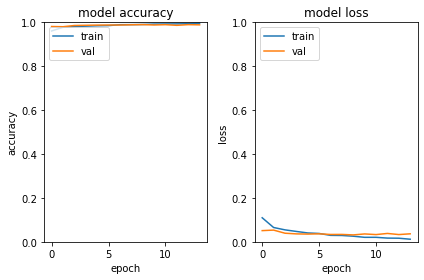

In [20]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(hist.history["accuracy"])
axs[0].plot(hist.history["val_accuracy"])
axs[0].set_title("model accuracy")
axs[0].set_ylabel("accuracy")
axs[0].set_xlabel("epoch")
axs[0].set_ylim(0, 1)
axs[0].legend(["train", "val"], loc="upper left")

axs[1].plot(hist.history["loss"])
axs[1].plot(hist.history["val_loss"])
axs[1].set_title("model loss")
axs[1].set_ylabel("loss")
axs[1].set_xlabel("epoch")
axs[1].set_ylim(0, 1)
axs[1].legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(p_dir, "accuracy_loss.jpg"))

# Confusion matrix

In [21]:
model.load_weights(os.path.join(p_dir, "{}".format(m_name)))

## Training data (in-sample)

In [22]:
x_train_tok = tokenize(x_train_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)

y_train_prob = model.predict(x_train_tok[:2], steps=y_train_b.shape[0])
y_pred = np.argmax(y_train_prob, axis=1)
y_pred = lb.inverse_transform(y_pred)

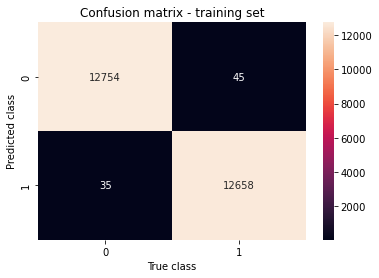

Accuracy: 1.00
Micro precision: 1.00
Micro recall: 1.00
Micro F1-score: 1.00
Macro precision: 1.00
Macro recall: 1.00
Macro F1-score: 1.00
Weighted precision: 1.00
Weighted recall: 1.00
Weighted F1-score: 1.00


In [23]:
cmtx = confusion_matrix(y_train, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - training set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_train.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_train, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_train, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_train, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_train, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_train, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_train, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_train, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="weighted")))

## Test data (out-of-sample)

In [24]:
x_test_pp = preprocess_data(x_test)
x_test_tok = tokenize(x_test_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_test_b = lb.transform(y_test)

y_test_prob = model.predict(x_test_tok[:2], steps=y_test_b.shape[0])
y_pred = np.argmax(y_test_prob, axis=1)
y_pred = lb.inverse_transform(y_pred)

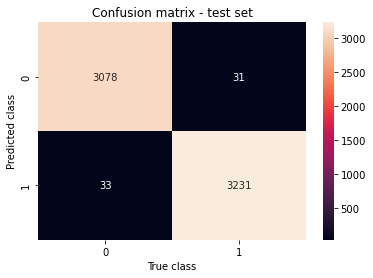

Accuracy: 0.99
Micro precision: 0.99
Micro recall: 0.99
Micro F1-score: 0.99
Macro precision: 0.99
Macro recall: 0.99
Macro F1-score: 0.99
Weighted precision: 0.99
Weighted recall: 0.99
Weighted F1-score: 0.99


In [25]:
cmtx = confusion_matrix(y_test, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - test set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_test.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_test, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_test, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_test, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="weighted")))

# print(classification_report(y_test, y_pred, target_names=lb.classe_))

# ROC curve

## Training data (in-sample)

In [26]:
lb = LabelBinarizer()
lb.fit_transform(y_train)

y_train_no = lb.fit_transform(y_train)
y_pred_no = y_train_prob[:, 1]
fpr, tpr, thr = roc_curve(y_train_no, y_pred_no)

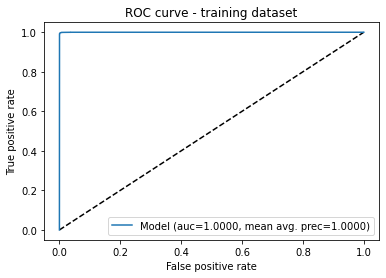

In [27]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_train_no, y_pred_no)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - training dataset")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_train.jpg"))
plt.show()

## Test data (out-of-sample)

In [28]:
lb = LabelBinarizer()
lb.fit_transform(y_train)

y_test_no = lb.fit_transform(y_test)
y_pred_no = y_test_prob[:, 1]
fpr, tpr, thr = roc_curve(y_test_no, y_pred_no)

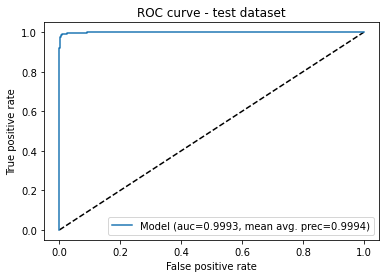

In [29]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_test_no, y_pred_no)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - test dataset")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_test.jpg"))
plt.show()

# Class probability histograms

## Without middle classes

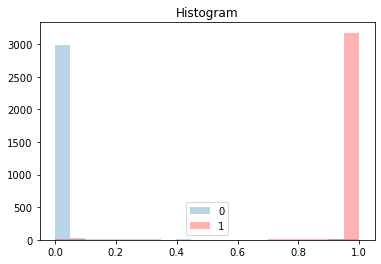

In [30]:
m0 = y_test_no[:, 0] == 0
c0 = y_test_prob[m0, 1]
m1 = y_test_no[:, 0] == 1
c1 = y_test_prob[m1, 1]

plt.hist(c0, alpha=0.3, bins=20)
plt.hist(c1, color="red", alpha=0.3, bins=20)
plt.title("Histogram")
plt.legend(lb.classes_)
plt.savefig(os.path.join(p_dir, "histogram.jpg"))
plt.show()

# Sample titles

In [31]:
combo = pd.concat([x_test, y_test], axis=1)
combo.reset_index(drop=True, inplace=True)
combo = pd.concat([combo, pd.Series(y_pred, name="pred")], axis=1)
combo.rename(columns={"clickbait": "truth"}, inplace=True)
combo.shape

(6373, 3)

In [32]:
g = combo.groupby(["pred"], as_index=False).apply(lambda x: x.sample(5, random_state=682))
g[["title", "pred"]].head(10)
g.to_csv(os.path.join(p_dir, "titles.csv"), index=False)
g.head(10)

title  truth  pred
0 1913            Afghan Legislator Killed in Bomb Attack      0     0
  204          Jonathan Ross announces departure from BBC      0     0
  5665        Purdue Finally Advances Past North Carolina      0     0
  4934  Scholarships awarded to isolated pacific islan...      0     0
  5204            Gallinari Eyes Return Despite Back Pain      0     0
1 724                   The 24 Best Fiction Books Of 2015      1     1
  2099  This Is The Only Way You Should Be Eating Pump...      1     1
  2264  The 27 Most Important Things Cats Did On The I...      1     1
  4350                  How Well Do You Know "Portlandia"      1     1
  3595        If You Were A Herb, What Would Your Name Be      1     1

# Save test set pred

In [33]:
y_pred_test = pd.Series(y_pred, name="y_pred_test")
y_pred_test.to_pickle(os.path.join(p_dir, "y_pred_test.pkl"))

# Apply model on Youtube data

In [34]:
import pandas as pd
import os
import numpy as np

In [35]:
m_dir = r"../nlp models/distilbert_2_classes_v3"

x_alien = pd.read_pickle(os.path.join(m_dir, "x_train.pkl"))
y_alien = pd.read_pickle(os.path.join(m_dir, "y_train.pkl"))

In [37]:
x_alien_pp = preprocess_data(x_alien)
x_alien_tok = tokenize(x_alien_pp, tok)

y_alien_prob = model.predict(x_alien_tok[:2], steps=y_alien.shape[0])
y_pred = np.argmax(y_alien_prob, axis=1)

In [38]:
x_combo = pd.concat([x_alien.reset_index(), y_alien.reset_index(), pd.Series(y_pred, name="pred")], axis=1)

In [39]:
x_combo[["title", "qtl", "pred"]].iloc[412:418, :]

,title,qtl,pred
412,This is why we can't have nice things,very high,1
413,Spring Full Course - Learn Spring Framework In...,very low,1
414,Platinum (version 2) - Periodic Table of Videos,very high,0
415,When To Quit (According to Computer Science),very high,1
416,Have astronomers disproved the Big Bang?,very high,0
417,Outtakes #1: Crash Course Philosophy,very low,1


In [40]:
x_combo["y"] = (x_combo["qtl"] == "very high").astype("int32")
x_combo["y"].corr(x_combo["pred"])

0.23250731843400244